# Beat Saber Map Generator


Imports

In [1]:
#!pip install tqdm

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torchinfo import summary

import matplotlib.pyplot as plt
import IPython
from tqdm.auto import tqdm

import song_loader
import note_processer
import audio_loader
import song_converter

import os
import re

print(torch.cuda.is_available())  
torch.set_default_device('cuda')

True


## Useful constants, classes, and other hyperparameters

In [3]:
sample_rate = 16000
song_length = 60
goal_bpm = 150
freq_bins = 128
note_total = int(song_length * 12 * goal_bpm/60)

a_loader = audio_loader.AudioLoader(goal_bpm=goal_bpm, 
                                    sample_rate=sample_rate, 
                                    freq_bins=freq_bins, 
                                    song_length=song_length)

## Verify helper classes are functioning

In [4]:
test_song_path = "./data/1cd59 (PanicPopFESTIVAL!!! - Shan_Man & Nolanimations)"
test_song_bpm = 230

In [5]:
song_data = song_loader.load_song(test_song_path)


song_tensors = []

for song in song_data.keys():
    song_tensor = note_processer.preprocess(song_data[song])
    song_tensors.append(song_tensor)

In [6]:
audio_path = test_song_path + "/song.egg"

In [7]:
audio = a_loader.load_audio(audio_path)

audio = torch.nn.functional.pad(audio, (0, song_length * sample_rate - audio.shape[-1]))

# Removes the top band because 128 better than 129
specgram = a_loader.convert_to_spectrogram(audio)

a_loader.fft_window_to_seconds = (specgram.shape[-1] - 1)/song_length
print(f'Spectrogram scale factor = {a_loader.fft_window_to_seconds}')

rescaled_specgram = a_loader.rescale_to_bpm(specgram, test_song_bpm)
rescaled_specgram = a_loader.rescale_to_quantized(specgram)

rescaled_specgram = a_loader.pad_to_length(rescaled_specgram)

specgram = torch.abs(specgram).pow(2)
rescaled_specgram = torch.abs(rescaled_specgram).pow(2)

print(rescaled_specgram.shape)
print(audio.device)

Spectrogram scale factor = 125.0
torch.Size([128, 3600])
cpu


In [8]:
#IPython.display.Audio(audio, rate=sample_rate)

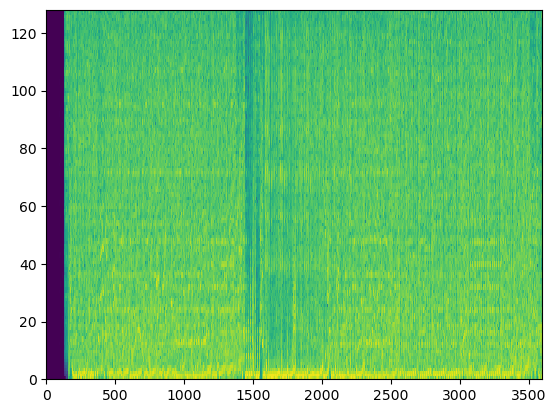

In [9]:
a_loader.plot_spectrogram(rescaled_specgram)

## Dataset

In [10]:
class Songs(torch.utils.data.Dataset):

    def __init__(self, path='./data/'):

        all_song_data = os.listdir(path)

        self.all_level_data = []

        for level_path in tqdm(all_song_data[:5]):

            if re.search('\(\d\)\s*$', level_path):
                print(f'Skipping {level_path}')
                continue
            
            print(f'Loading {level_path}')

            song_data = song_loader.load_song(test_song_path)

            song_tensors = []
            
            for song in song_data.keys():
                song_tensor = note_processer.preprocess(song_data[song])
                song_tensor = torch.Tensor(song_tensor)
                song_tensor = torch.reshape(song_tensor, (-1, 228))
  
                song_tensor = torch.nn.functional.pad(song_tensor, (0,0, 0, note_total - song_tensor.shape[0]))
                song_tensor = torch.reshape(song_tensor, (1, -1, 228))
                song_tensor = song_tensor.to(device='cpu')
                song_tensors.append(song_tensor)
                ############### REMOVE #############
                

            audio = a_loader.load_audio(audio_path)

            audio = torch.nn.functional.pad(audio, (0, song_length * sample_rate - audio.shape[-1]))
            
            # Removes the top band because 128 better than 129
            specgram = a_loader.convert_to_spectrogram(audio)
            
            rescaled_specgram = a_loader.rescale_to_bpm(specgram, test_song_bpm)
            rescaled_specgram = a_loader.rescale_to_quantized(specgram)
            
            rescaled_specgram = a_loader.pad_to_length(rescaled_specgram)
            
            specgram = torch.abs(specgram).pow(2)
            rescaled_specgram = torch.abs(rescaled_specgram).pow(2)
            rescaled_specgram = rescaled_specgram.to(device='cpu')
            rescaled_specgram = torch.reshape(rescaled_specgram, (1, freq_bins, -1))

            for song in song_tensors:
                self.all_level_data.append([rescaled_specgram, song])

    def __len__(self):
        return len(self.all_level_data)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return self.all_level_data[idx]

In [11]:
dataset = Songs()

  0%|          | 0/5 [00:00<?, ?it/s]

Loading 10cfd (Sakura - MeezoNugget & GalaxyMaster)
Loading 11050 (The Rest Of Life - LoveLessDark)
Skipping 11050 (The Rest Of Life - LoveLessDark) (1)
Loading 116b0 (Lost Memory - waika)
Loading 1188e (All Eyes On Me - nitronik.exe)


In [12]:
batch_size = 16
all_maps = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle=False)

## Models


In [13]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.hidden_dim = 1
        self.kernel = 15
        self.pool_kernel = (4,2)
        self.pool_stride = (4,2)
        self.transformer_layers = 3
        self.transformer_feedforward_dim = 32
        self.attention_heads = 4

        self.encode_size = int(32 * self.hidden_dim * (freq_bins/self.pool_stride[0]))
        
        # Initial: 1, 128, sec * 60

        # Embedding Layers
        # 16, 128, sec * 60
        self.emb_conv1 = nn.Conv2d(1, 16 * self.hidden_dim, kernel_size=self.kernel, padding='same')
        # 16, 32, sec * 30
        self.max_pool = nn.MaxPool2d(kernel_size=self.pool_kernel, stride=self.pool_stride)
        # 32, 32, sec * 30
        self.emb_conv2 = nn.Conv2d(16 * self.hidden_dim, 32 * self.hidden_dim, kernel_size=self.kernel, padding='same')
        self.emb_dense = nn.Linear(self.encode_size, 19 * 12)
        self.out_dense = nn.Linear(19 * 12, 19 * 12)
        self.relu = nn.ReLU()
        
        # Transformer Layers
        self.encode_transformer_layer = nn.TransformerEncoderLayer(
            d_model = 228,
            nhead = self.attention_heads,
            dim_feedforward = self.transformer_feedforward_dim
        )
        self.encoder = nn.TransformerEncoder(
            self.encode_transformer_layer,
            num_layers=self.transformer_layers
        )

        self.decode_transformer_layer = nn.TransformerDecoderLayer(
            d_model = int(12 * 19),
            nhead = self.attention_heads,
            dim_feedforward = self.transformer_feedforward_dim

        )
        self.decoder = nn.TransformerDecoder(
            self.decode_transformer_layer,
            num_layers = self.transformer_layers
        )

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):

        x += 1e-4 * torch.randn_like(x)
        # Encode audio into embedding
        x = self.emb_conv1(x)
        x = self.max_pool(x)
        
        x = self.emb_conv2(x)

        x = torch.reshape(x, (-1, song_length * 30, self.encode_size))  
        x = self.emb_dense(x)
        
        # Flatten audio embedding and generate output shape

        out = torch.zeros(x.shape[0], song_length * 30, 228)
        
        # Pass through the transformer
        x = self.encoder(x)
        
        out = self.decoder(out, x)
        out = self.out_dense(out)
        out = self.relu(out)
        out = out.view(-1, song_length * 30, 3, 4, 19)
        out = self.softmax(out)
        out = torch.reshape(out, (-1, 1, note_total, 228))
        
        
        # Return final value
        return out

In [14]:
def calc_conv_size(l, s, k):
    return int(np.floor((l-k)/s))+1

class Discriminator(nn.Module):

    def __init__(self):

        super().__init__()

        self.hidden_dim = 1
        self.kernel = 15
        self.pool_kernel = (4,4)
        self.pool_stride = (4,4)
        self.pool_kernel_1D = 4
        self.pool_stride_1D = 4
        self.lin_size = calc_conv_size(calc_conv_size(note_total/4,4,4), 1, 14)
        print(self.lin_size)
        self.lin_layer_size = calc_conv_size(calc_conv_size(self.lin_size, 4, 4), 4, 4) * 32
        

        # 8, 10800, 228
        self.conv1 = nn.Conv2d(1, 8*self.hidden_dim, kernel_size=self.kernel, padding='same')
        # 8, 2700, 57
        self.max_pool1 = nn.MaxPool2d(self.pool_kernel, self.pool_stride)
        # 16, 2700, 57
        self.conv2 = nn.Conv2d(8 * self.hidden_dim, 16 * self.hidden_dim, kernel_size=self.kernel, padding='same')
        # 16, 675, 15
        self.max_pool2 = nn.MaxPool2d(self.pool_kernel, self.pool_stride)
        # 32, 662, 1
        self.conv3 = nn.Conv2d(16 * self.hidden_dim, 32 * self.hidden_dim, kernel_size=14)
        # Flatten to 32, 662
        # 32, 165
        self.max_pool3 = nn.MaxPool1d(self.pool_kernel_1D, self.pool_stride_1D)
        # 32, 41
        self.max_pool4 = nn.MaxPool1d(self.pool_kernel_1D, self.pool_stride_1D)
        # Flatten to 1344
        self.dense = nn.Linear(self.lin_layer_size, self.lin_layer_size//2)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(self.lin_layer_size//2, self.lin_layer_size//8)
        self.dense3 = nn.Linear(self.lin_layer_size//8, 1)


    def forward(self, x):

        x = self.conv1(x)
        x = self.max_pool1(x)
        
        x = self.conv2(x)
        x = self.max_pool2(x)
        
        x = self.conv3(x)
        
        x = torch.reshape(x, (-1, 32, self.lin_size))
        
        x = self.max_pool3(x)
        
        x = self.max_pool4(x)

        x = torch.reshape(x, (-1, self.lin_layer_size))
  
        
        x = self.dense(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        # x = torch.sigmoid(x)
        return x

In [15]:
def get_gradient(critic, real, fake, epsilon):

    mix = torch.sum(real * epsilon + fake * (1-epsilon), 1, keepdim=True)
    
    score = critic(mix)
    gradient = torch.autograd.grad(
        inputs = mix,
        outputs = score,
        grad_outputs = torch.ones_like(score),
        create_graph = True,
        retain_graph = True
    )[0]
    return gradient
    


def gradient_penalty(grad):

    grad = grad.view(len(grad), -1)
    grad_norm = grad.norm(2, dim=1)

    penalty = torch.mean((grad_norm - 1) ** 2)
    return penalty

def get_gen_loss(crit_fake_pred):
    return -torch.mean(crit_fake_pred)
    

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = -(torch.mean(crit_real_pred) - torch.mean(crit_fake_pred) - gp*c_lambda)
    return crit_loss
    


## Training Preparations

In [16]:
n_epochs = int(5e3)
lrg = 1e-5
lrd = 1e-5

In [17]:
gen = Generator()
gen_opt = torch.optim.Adam(gen.parameters(), lr=lrg)

disc = Discriminator()
disc_opt = torch.optim.Adam(disc.parameters(), lr=lrd)

map_to_map_loss = nn.BCELoss()

# def weights_init(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#         torch.nn.init.normal_(m.weight, 0.0, 0.0002)
#     if type(m) == nn.Linear:
#         nn.init.uniform_(m.weight, a=-0.001, b=0.001)
# gen = gen.apply(weights_init)
# disc = disc.apply(weights_init)  

print(rescaled_specgram.shape)
print(disc(gen(torch.reshape(rescaled_specgram, (1, 128, song_length * 60)))).shape)

99
torch.Size([128, 3600])
torch.Size([1, 1])


In [18]:
print(summary(gen, (1,128, song_length * 60)))
print('\\/'*50)
print('/\\'*50)
print(summary(disc, (1,note_total,228)))

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     [1, 1, 1800, 228]         658,528
├─Conv2d: 1-1                                 [16, 128, 3600]           3,616
├─MaxPool2d: 1-2                              [16, 32, 1800]            --
├─Conv2d: 1-3                                 [32, 32, 1800]            115,232
├─Linear: 1-4                                 [1, 1800, 228]            233,700
├─TransformerEncoder: 1-5                     [1, 1800, 228]            --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 1800, 228]            224,612
│    │    └─TransformerEncoderLayer: 3-2      [1, 1800, 228]            224,612
│    │    └─TransformerEncoderLayer: 3-3      [1, 1800, 228]            224,612
├─TransformerDecoder: 1-6                     [1, 1800, 228]            --
│    └─ModuleList: 2-2                        --              

## Training

In [21]:
display_rate = 20
gen_display_rate = 20
c_lambda = 10

blank_map = torch.zeros_like(dataset[0][1].reshape(-1, 1, note_total, 228)).to(device='cuda')
for i in range(228):
    if i%19==0:
        blank_map[:, :, :, i] = 1
print(blank_map.shape)

torch.Size([1, 1, 1800, 228])


In [24]:
gen_losses = []
disc_losses = []

disc_repeats = 1
gen_repeats = 1

print('Adversarial Training')
# Adversarial Training
for i in tqdm(range(n_epochs)):

    batch_gen_loss = []
    batch_disc_loss = []
    batch_fake_val = [0]
    batch_real_val = [0]
    
    for specgrams, maps in all_maps:

        empty_map = blank_map.broadcast_to(maps.shape[0], 1, note_total, 228)

        specgrams = specgrams.to(device='cuda')
        maps = maps.to(device='cuda')

        disc_mean_iter_loss = 0

        fake_avg = 0
        real_avg = 0
        
        fake_cache = None
        
        for _ in range(np.max(disc_repeats, 0)):

            # Zero gradients for batch/iteration
            disc_opt.zero_grad()

            fake_maps = None
            # Generate fake maps
            if fake_cache is None:
                fake_maps = gen(specgrams)
                fake_cache = fake_maps
            else:
                fake_maps = fake_cache

            disc_fake_pred = disc(fake_maps)
            disc_real_pred = disc(maps)
    
            epsilon = torch.rand(len(maps), 1, 1, device='cuda', requires_grad=True)
            gradient = get_gradient(disc, maps, fake_maps.detach(), epsilon)
            gp = gradient_penalty(gradient)
            disc_loss = get_crit_loss(disc_fake_pred, disc_real_pred, gp, c_lambda)

            disc_loss.backward(retain_graph=True)
            disc_opt.step()

            fake_avg += torch.mean(disc_fake_pred).item()
            real_avg += torch.mean(disc_real_pred).item()
            
            disc_mean_iter_loss += disc_loss.item()

        fake_avg /= disc_repeats        
        fake_avg /= disc_repeats

        disc_mean_iter_loss /= disc_repeats

        for _ in range(gen_repeats):
            # Zero gradients for batch
            gen_opt.zero_grad()
            
            # Get predictions
            generated = gen(specgrams)
            fake_pred = disc(generated)
            
            # Calculate loss
            error_gen = get_gen_loss(fake_pred)
            map_loss = map_to_map_loss(generated, empty_map)

            if(i%gen_display_rate==0):
                print(error_gen.item())
                print(map_loss.item())

            # Calculate gradients
            error_gen.backward(retain_graph=True)
            map_loss.backward()

    
            # Calculate loss 
            gen_loss = error_gen.item() + map_loss.item()
    
            # Run optimizing step
            gen_opt.step()

        # batch_gen_loss.append(gen_loss)
        batch_disc_loss.append(disc_mean_iter_loss)
        batch_gen_loss.append(gen_loss)
        batch_fake_val.append(fake_avg)
        batch_real_val.append(real_avg)
    
    disc_losses.append(torch.mean(torch.Tensor(batch_disc_loss)).item())
    gen_losses.append(torch.mean(torch.Tensor(batch_gen_loss)).item())
    if i%display_rate == 0:
        print(f'Loss: {disc_losses[-1]}, Real avg: {batch_real_val[-1]}, Fake avg: {batch_fake_val[-1]}')
    if i% gen_display_rate == 0:
        new_map = gen(torch.reshape(specgrams[0].to(device='cuda'), (1, 128, -1)))
        spot = int(torch.rand(1) * len(new_map))
        map_layer_1 = new_map.view(-1,3,4,19)[spot]
        print(torch.max(map_layer_1, -1))
    
plt.plot(np.arange(n_epochs), gen_losses)
plt.plot(np.arange(n_epochs), disc_losses)
plt.show()

Adversarial Training


  0%|          | 0/5000 [00:00<?, ?it/s]

-0.057678356766700745
0.13567614555358887
-0.05745755508542061
0.13534125685691833
Loss: 9.702315330505371, Real avg: 0.08104191720485687, Fake avg: 0.05769994109869003
torch.return_types.max(
values=tensor([[0.0942, 0.1217, 0.2400, 0.1458],
        [0.2491, 0.1972, 0.2519, 0.2693],
        [0.3658, 0.0876, 0.5368, 0.1886]], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([[16,  0,  0,  9],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]], device='cuda:0'))
-0.042493000626564026
0.1025308147072792
-0.0421459823846817
0.10326159000396729
Loss: 9.608039855957031, Real avg: 0.10743878781795502, Fake avg: 0.042525313794612885
torch.return_types.max(
values=tensor([[0.0892, 0.1517, 0.5001, 0.2644],
        [0.3493, 0.2619, 0.3297, 0.2923],
        [0.4216, 0.2003, 0.2554, 0.3198]], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([[16,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]], device='cuda:0'))
-0.020390084013342857
0.089491508901119

KeyboardInterrupt: 

## Export Test

In [57]:
new_map = gen(torch.reshape(dataset.all_level_data[0][0].to(device='cuda'), (1, 128, -1)))
# print(new_map.view(-1,3,4,19)[:2])
v = torch.argmax(new_map.view(-1,12,19), dim=-1).to(torch.float32)
print(v)
# for vl in v:
#     print(vl)
m = torch.mean(v, dim=-2)
print(m[0:4])
print(m[4:8])
print(m[8:12])

tensor([[ 0.,  0.,  0.,  ...,  0.,  0., 18.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 18.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 18.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0., 18.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 18.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 18.]], device='cuda:0')
tensor([0.0000, 0.0294, 0.0150, 0.0406], device='cuda:0')
tensor([0.0000, 0.0139, 0.0067, 0.0617], device='cuda:0')
tensor([2.0000e-02, 1.0000e-02, 1.5000e-02, 1.8000e+01], device='cuda:0')


In [28]:
new_map = gen(torch.reshape(dataset.all_level_data[0][0].to(device='cuda'), (1, 128, -1)))
out_path = './out/'
song_converter.export_and_save(out_path, 'PanicPopFESTIVAL!!!', 'DJ Genki', test_song_bpm, new_map)

Constructing Level File
torch.Size([1800, 3, 4, 19])
Building Info File
Saving Data
Please add song to ./out/PanicPopFESTIVAL!!!
Export Complete


In [ ]:
print()